<a href="https://colab.research.google.com/github/Soumya296/Deep_learning/blob/master/Hand_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#essential_libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import csv

#Deep learning framework
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense , Conv2D , Flatten ,MaxPool2D

In [2]:

tf.__version__

'2.3.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Projects
os.getcwd()

/content/drive/My Drive/Projects


'/content/drive/My Drive/Projects'

In [6]:
!ls

My_model.h5py  sign_mnist_test.csv  sign_mnist_train.csv  training_1


In [7]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


In [9]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)


In [10]:
def get_data(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        temp_images = []
        temp_labels = []
        for row in csv_reader:
            if first_line:
                # print("Ignoring first line")
                first_line = False
            else:
                temp_labels.append(row[0])
                image_data = row[1:785]
                image_data_as_array = np.array_split(image_data, 28)
                temp_images.append(image_data_as_array)
        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')
    return images, labels

training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [11]:
training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

print(training_images.shape)
print(testing_images.shape)



(27455, 28, 28, 1)
(7172, 28, 28, 1)


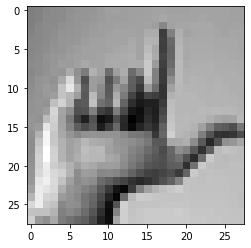

In [12]:
plt.imshow(training_images[51].reshape((28,28)),cmap ='gray')

In [13]:
training_gen = train_datagen.flow(training_images, training_labels, batch_size=32)
validation_gen=validation_datagen.flow(testing_images, testing_labels, batch_size=32)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer = 'he_normal',use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer = 'he_normal',use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer = 'he_normal',use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax)])

# Compile Model. 
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(training_gen,
                              steps_per_epoch=len(training_images) / 32,
                              epochs=150,
                              validation_data = validation_gen,
                              validation_steps=len(testing_images) / 32,
                              callbacks = [cp_callback])

# training_images = training_images/255
testing_images = testing_images/255
# history = model.fit(x=training_images,y=training_labels,epochs = 150,batch_size = 32,validation_data = (testing_images,testing_labels))
model.evaluate(testing_images, testing_labels)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
854/857 [============================>.] - ETA: 0s - loss: 2.7405 - accuracy: 0.1793
Epoch 00001: val_loss improved from inf to 3.74876, saving model to training_1/cp.ckpt
858/857 [==============================] - 12s 14ms/step - loss: 2.7384 - accuracy: 0.1797 - val_loss: 3.7488 - val_accuracy: 0.1520
Epoch 2/150
858/857 [==============================] - ETA: 0s - loss: 1.9878 - accuracy: 0.3597
Epoch 00002: val_loss improved from 3.74876 to 1.19013, saving model to training_1/cp.ckpt
858/857 [==============================] - 11s 13ms/step - loss: 1.9878 - accuracy: 0.3597 - val_loss: 1.1901 - val_accuracy: 0.5929
Epoch 3/150
857/857 [============================>.] - ETA: 0s - loss: 1.6502 - accuracy: 0.4600
Epoch 00003: val_loss improved from 1.19013 to 0.97372, saving model to training_1/cp.ckpt
858/857 [==============================] - 11s 13ms/step - loss: 1.6502 - accuracy: 0.4600 - val_l

[0.07230984419584274, 0.9803401827812195]

In [15]:
model.load_weights(checkpoint_path)

In [16]:
model.evaluate(testing_images,testing_labels)

225/225 [==============================] - 1s 3ms/step - loss: 0.0422 - accuracy: 0.9888


[0.04222554713487625, 0.9888455271720886]

In [17]:
model.save('My_model.h5py')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: My_model.h5py/assets


In [19]:
model_temp = keras.models.load_model('My_model.h5py')
model_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1